# The Hamiltonian

The electric and magnetic Hamiltonians in the $|0\rangle$, $| 1 \rangle$ truncation are:

$$ H_E = \frac{8}{3}g^2 \sum_{p} \hat{P}_{1,p} $$

$$ H_B = -\frac{1}{2g^2} \sum_{p} \left( \hat{P}_{1,p} + \sqrt{2} \hat{P}_{0,p+\hat{x}} \hat{P}_{0,p-\hat{x}} \hat{P}_{0,p+\hat{y}} \hat{P}_{0,p-\hat{y}} \hat{X}_{p}  \right) $$

where $\hat{P}_{0,p}=\ket{0}\bra{0}_p$ is the projector onto the $\ket{0}$ state on plaquette $p$, and $\hat{P}_{1,p}=\ket{1}\bra{1}_{p}$ is the proctor onto the $\ket{1}$ state on plaquette $p$.

In what follows, the part of the magnetic Hamiltonian that looks like $-\frac{1}{2g^2} P_1$ is removed.

In [3]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigsh
from scipy.sparse import kron, eye, csr_matrix
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
import scipy.linalg as linalg

In [4]:

'''
We'll need to define functions that implements the operators in the Hamiltonian, namely the P_1 and PPPPX operators.
Want to work with sparse matrices.
'''

# Create the one-qubit operations
Id =  sparse.csr_matrix(np.array([[1.,0.],[0.,1.]]))
P1 = sparse.csr_matrix(np.array([[0., 0.],[0., 1.]]))
P0 = sparse.csr_matrix(np.array([[1.,0.],[0.,0.]]))
Xop = sparse.csr_matrix(np.array([[0.,1.],[1.,0.]]))
Yop = sparse.csr_matrix(np.array([[0.,1j],[-1j,0.]]))

# Define a function that acts with a one-qubit operator on a specified qubit. So, it takes in a 2x2 matrix and spits out a 2^n x 2^n matrix.
def one_qubit_gate(M, p, L):
    n = L*L
    result = eye(1, format='csr') # create a sparse 1x1 matrix to store result
    # kronecker together a bunch of identities, and the 2x2 matrix M in the proper location p
    for i in range(n):
        if (i==p):
            result = kron(result, M, format='csr')
        else:
            result = kron(result, Id, format='csr')  
    return result



# Define a function that acts with X on a specified location p, with P0 on a list of specified locations (p1, p2, p3, p4) 
def PXP_gate(p, p_list, L):
    n = int(L*L)
    result = eye(1, format='csr')
    for i in range(n):
        if (i==p):
            result = kron(result, Xop, format='csr')
        elif (i in p_list):
            result = kron(result, P0, format='csr')
        else:
            result = kron(result, Id, format='csr')
    return result

In [15]:
'''
Convert between the single-index p which enumerates qubits, and double-index (i,j) which enumerates lattice sites
'''

def map_to_circuit(i,j,L=4):
    return i*L + j

def map_to_lattice(i,L=4):
    return i // L, i % L


''' 
Create a function that produces the Hamiltonian matrix
'''

def make_electric_ham(g, L=4):
    # Returns a sparse 2**n x 2**n matrix containing the diagonal part of the Hamiltonian
    n = L*L
    elec_prefactor = (8./3.)*g*g
    
    H_E = csr_matrix((2**n, 2**n))
    for p in range(n):
        H_E += one_qubit_gate(P1, p, L)
    return elec_prefactor*H_E



def make_magnetic_ham(g, L=4, boundary='periodic'):
    # Returns a sparse 2**n x 2**n matrix containing the PXP part of the Hamiltonian
    n = L*L
    mag_prefactor = -np.sqrt(2)/(2*g*g)

    H_B = csr_matrix((2**n, 2**n))
    if (boundary == 'periodic'):
        for p in range(n):
            i, j = map_to_lattice(p, L)
            nl   = map_to_circuit((i - 1) % L, j, L)
            nd   = map_to_circuit(i, (j - 1) % L, L)
            nr   = map_to_circuit((i + 1) % L, j, L)
            nu   = map_to_circuit(i, (j + 1) % L, L)
            H_B += PXP_gate(p, [nl, nd, nr, nu], L)
    return mag_prefactor*H_B

def make_energy_penalty(L, boundary='periodic'):
    # Return a term that penalizes unphysical states (states where two neigboring plaquettes are excited
    n = L*L
    H_pen = csr_matrix((2**n, 2**n))
    for p in range(n):
        i, j = map_to_lattice(p, L)
        nu   = map_to_circuit(i, (j + 1) % L, L)
        nr   = map_to_circuit((i + 1) % L, j, L)
        H_pen += one_qubit_gate( P1, p, L) @ one_qubit_gate( P1, nu, L)
        H_pen += one_qubit_gate( P1, p, L) @ one_qubit_gate( P1, nr, L)
    return H_pen
            

def make_ham(g, L=4, boundary='periodic', penalty=0):
    H_E = make_electric_ham(g, L)
    H_B = make_magnetic_ham(g, L, boundary=boundary)
    H_pen = penalty * make_energy_penalty(L, boundary=boundary)
    return H_E + H_B + H_pen


def get_ground_state_energy(g, L=4, boundary='periodic', penalty=0):
    H = make_ham(g, L, boundary=boundary, penalty=penalty)
    evals, evecs = eigsh( H, which='SA', k=1)
    return evals[0]

### Optimizer

In [6]:
from scipy.optimize import minimize

# Trial state

Following the rationale of ADAPT-VQE, the trial state will be of the form $\exp( \hat{\tau}_k \theta_k ) \, ... \, \exp( \hat{\tau}_1 \theta_1 ) \ket{0}$, where the operators $\hat{\tau}_i$ are anti-Hermitian operators drawn from a pool of operators, and are of the same form (respecting the same symmetries) as the terms in the Hamiltonian, and in addition are purely real operators. 

To start off, the operator pool will consist of a single operator: $\tau = i \sum_{p} \hat{Y}_p \prod_{q \in \partial p} \hat{P}_{0,q} $. This operator is of the same form as the PXP term in the Hamiltonian, but it is purely real and anti-Hermitian, so that it will generate a purely real trial state.

Then on a first pass, our trial state is

$$ \ket{\psi(\theta)} = \exp( i \theta \sum_{p} \hat{Y}_p \prod_{q \in \partial p} \hat{P}_{0,q} ) \ket{0}  $$

with a single variational parameter, $\theta$. Since this mimicks the time evolution under the Hamiltonian $H' = \sum_{p} \hat{Y}_p \prod_{q \in \partial p} \hat{P}_{0,q}$, I'll call this the 'Y-magnetic ansatz'.

In [7]:
from scipy.sparse.linalg import expm

# Define a function that acts with Y on a specified location p, with P0 on a list of specified locations (p1, p2, p3, p4) 
def PYP_gate(p, p_list, L=4):
    n = int(L*L)
    result = eye(1, format='csr')
    for i in range(n):
        if (i==p):
            result = kron(result, Yop, format='csr')
        elif (i in p_list):
            result = kron(result, P0, format='csr')
        else:
            result = kron(result, Id, format='csr')
    return result

def make_Y_magnetic_ham(L, boundary='periodic'):
    # Returns a sparse 2**n x 2**n matrix containing the PYP part of the Hamildtonian
    n = L*L
    H = csr_matrix((2**n, 2**n))
    if (boundary == 'periodic'):
        for p in range(n):
            i, j = map_to_lattice(p, L)
            nl   = map_to_circuit((i - 1) % L, j, L)
            nd   = map_to_circuit(i, (j - 1) % L, L)
            nr   = map_to_circuit((i + 1) % L, j, L)
            nu   = map_to_circuit(i, (j + 1) % L, L)
            H += PYP_gate(p, [nl, nd, nr, nu], L)
    return H


def Y_magnetic_ansatz_operator(L, theta):
    # Return the 2^L x 2^L matrix giving the operator enacting the Y magnetic ansatz
    H = make_Y_magnetic_ham(L)
    return expm(1j * theta * H)

def Y_magnetic_ansatz(L, theta):
    # Return the variational ansatz state vector resulting from the Y magnetic ansatz
    H = Y_magnetic_ansatz_operator(L, theta)
    return H[:,0]

def Y_magnetic_ansatz_estimate_energy(theta_array, g, L, boundary='periodic', penalty=0):
    # Compute the expectation value <psi| H | psi> of the variational state |psi> with respect to the system Hamiltonian H.
    theta = theta_array[0]
    trial_state = Y_magnetic_ansatz(L, theta)
    H = make_ham(g, L, boundary=boundary, penalty=penalty)
    return np.real( np.conjugate(np.transpose(trial_state)) @ H @ trial_state )[0,0]



In [21]:
g = 1.
L = 3
boundary = 'periodic'
penalty = 0

def Y_magnetic_ansatz_cost_function(theta_array):
    return Y_magnetic_ansatz_estimate_energy(theta_array, g, L, boundary=boundary, penalty=penalty)

theta0 = [0.1]

result = minimize(Y_magnetic_ansatz_cost_function, theta0, args=(), method='COBYLA', jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)

print( f"(Variational ground state energy) - (true ground state energy) = {result['fun'] - get_ground_state_energy(g, L, boundary=boundary, penalty=penalty)}" )
result

(Variational ground state energy) - (true ground state energy) = 0.0005617001197277816


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.3299697879000936
       x: [ 1.968e-01]
    nfev: 23
   maxcv: 0.0

## Performance as a function of coupling

In [18]:
L = 3
gvals = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2])
boundary = 'periodic'
penalty = 0

def Y_magnetic_ansatz_cost_function(theta_array):
    return Y_magnetic_ansatz_estimate_energy(theta_array, g, L, boundary=boundary, penalty=penalty)

theta0 = [0.1]

variational_ground_state_energies = []

for i in range(len(gvals)):
    g = gvals[i]
    h = make_ham(g, L, boundary=boundary, penalty=penalty)
    result = minimize(Y_magnetic_ansatz_cost_function, theta0, args=(), method='COBYLA', jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    variational_ground_state_energies.append( result['fun'] )
    print(f"Computation up to g={g} complete.", end='\r')

Computation up to g=1.1 complete.

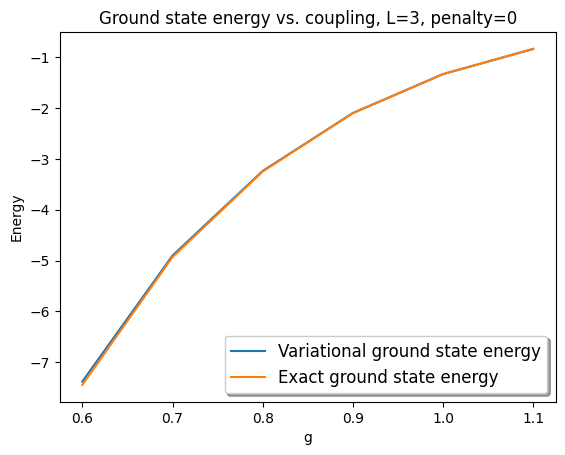

In [19]:
#Make plots
fig, ax = plt.subplots()

true_ground_state_energies = [ get_ground_state_energy(gi, L, boundary, penalty) for gi in gvals ]

plt.title(f"Ground state energy vs. coupling, L={L}, penalty={penalty}") 
plt.xlabel("g") 
plt.ylabel("Energy")

ax.plot( gvals, variational_ground_state_energies ,'-', label="Variational ground state energy")
ax.plot( gvals, true_ground_state_energies ,'-', label="Exact ground state energy")
legend = ax.legend(loc='best', shadow=True, fontsize='large')
plt.show()

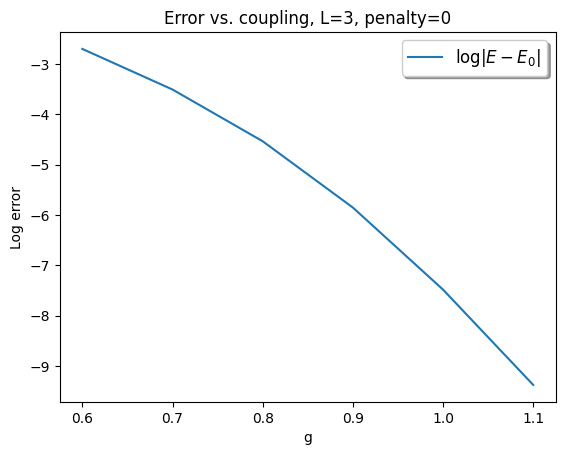

In [20]:
#Make plots
fig, ax = plt.subplots()

relative_error =  np.log( np.abs(  np.array(variational_ground_state_energies) - true_ground_state_energies ) ) 

plt.title(f"Error vs. coupling, L={L}, penalty={penalty}") 
plt.xlabel("g") 
plt.ylabel("Log error")

ax.plot( gvals, relative_error ,'-', label=r"$\log|E - E_0|$")
legend = ax.legend(loc='best', shadow=True, fontsize='large')
plt.show()

### L=4 VQE

In [ ]:
g = 1.2
L = 4
boundary = 'periodic'
penalty = 0

def Y_magnetic_ansatz_cost_function(theta_array):
    return Y_magnetic_ansatz_estimate_energy(theta_array, g, L, boundary=boundary, penalty=penalty)

theta0 = [0.1]

result = minimize(Y_magnetic_ansatz_cost_function, theta0, args=(), method='COBYLA', jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)

print( f"(Variational ground state energy) - (true ground state energy) = {result['fun'] - get_ground_state_energy(g, L, boundary=boundary, penalty=penalty)}" )
result

/Users/iriandandrea/opt/anaconda3/envs/qis/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/iriandandrea/opt/anaconda3/envs/qis/lib/python3.9/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
Traceback (most recent call last):
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
  File "/Users/iriandandrea/opt/anaconda3/envs/qis/lib/python3.9/site-packages/scipy/optimize/_cobyla_py.py", line 281, in calcfc
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    f = sf.fun(x)
  File "/Users/iriandandrea/opt/anaconda3/envs/qis/lib/python3.9/site-packages/scipy/optimize/_differentiable_functions.py", line 278, in fun
    self._update_fun()
  File 